In [1]:
import matplotlib.pyplot as plt
import numpy as np
from flow_policy.toy.flow_policy import FlowPolicy
from flow_policy.toy.plot_deterministic import (
    plot_probability_density,
    plot_probability_density_and_vector_field,
    plot_probability_density_and_streamlines,
    plot_probability_density_with_trajectories,
)

from pydrake.all import (
    CompositeTrajectory,
    PiecewisePolynomial,
    Trajectory,
)

# Set seed
np.random.seed(0)

In [2]:
def demonstration_traj_right() -> Trajectory:
    """
    Returns a trajectory x(t) that is 0 for 0 < t < 0.25, and a sine curve
    for 0.25 < t < 1 that starts at 0 and ends at 0.75.
    """
    piece_1 = PiecewisePolynomial.FirstOrderHold(
        breaks=[0, 0.25],
        samples=[[0, 0]],
    )
    piece_2 = PiecewisePolynomial.CubicWithContinuousSecondDerivatives(
        breaks=[0.25, 0.50, 0.75, 1.0],
        samples=[[0.00, 0.62, 0.70, 0.5]],
        sample_dot_at_start=[[0.0]],
        sample_dot_at_end=[[-0.7]],
    )
    return CompositeTrajectory([piece_1, piece_2])

def demonstration_traj_left() -> Trajectory:
    """
    Returns a trajectory x(t) that is 0 for 0 < t < 0.25, and a sine curve
    for 0.25 < t < 1 that starts at 0 and ends at 0.75.
    """
    piece_1 = PiecewisePolynomial.FirstOrderHold(
        breaks=[0, 0.25],
        samples=[[0, 0]],
    )
    piece_2 = PiecewisePolynomial.CubicWithContinuousSecondDerivatives(
        breaks=[0.25, 0.50, 0.75, 1.0],
        samples=[[0.00, -0.62, -0.70, -0.5]],
        sample_dot_at_start=[[0.0]],
        sample_dot_at_end=[[0.7]],
    )
    return CompositeTrajectory([piece_1, piece_2])

traj_right = demonstration_traj_right()
traj_left = demonstration_traj_left()

## Plot demonstration trajectories

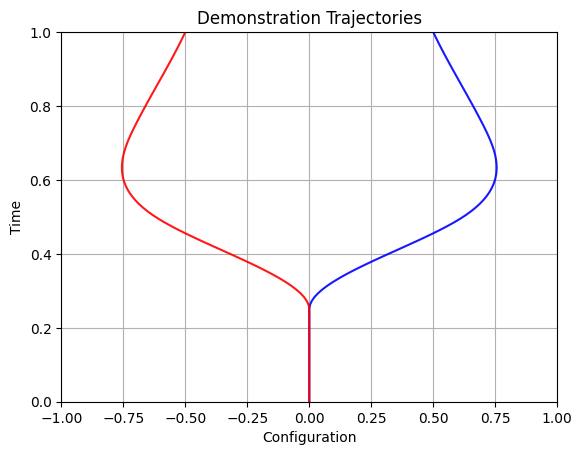

In [3]:
"""
Plot demonstration trajectory on x-y plane where x axis is the state in [-1, 1]
and y axis is the time in [0, 1].
"""
times = np.linspace(0, 1, 100)
plt.plot(traj_right.vector_values(times)[0], times, color='blue', alpha=0.9)
plt.plot(traj_left.vector_values(times)[0], times, color='red', alpha=0.9)
plt.xlim(-1, 1)
plt.ylim(0, 1)
plt.xlabel('Configuration')
plt.ylabel('Time')
plt.title('Demonstration Trajectories')
plt.grid(True)
plt.show()

### We need to learn multimodal trajectories for diffusion policy

![Diffusio policy](https://diffusion-policy.cs.columbia.edu/images/multimodal_sim.svg)


## Notation
| Symbol | Space | Meaning |
|:--------:|:-------:|:---------:|
| $t$ | $[0, 1]$ | Time |
| $q$ | $\mathbb{C}$| Configuration |
| $x = q$ | $\mathbb{C}$ | State (may not equal configuration in general) |
| $v$ | $\mathbb{C}$ | Velocity |
| $o$ |  | Observation history |
| $v_\theta(x, t \mid o)$ | $\mathbb{C}$ | Learned flow policy |
| $\xi \sim \mathcal{D}$ | $[0, 1] \rightarrow \mathbb{C}$ | Random variable for demonstration trajectories |
| $\xi(t)$ | $\mathbb{C}$ | Configuration in the demonstration at time $t$ |
| $\dot{\xi}(t)$ | $\mathbb{C}$ | Velocity in the demonstration at time $t$ |


In this notebook, $x \equiv q$.

## Conditional flow

In [4]:
fp = FlowPolicy(trajectories=[traj_right], prior=[1.0], sigma=0.05)

Given $\xi \sim \mathcal{D}$ with associated observation history $o$, we will define a conditional flow field $v_\theta(x, t \mid o)$ that must be learned.

\begin{align*}
q_0 &\sim \mathcal{N}(\xi(0), \sigma^2) \\
q(t \mid \xi) &= q_0 + \xi(t) - \xi(0)\\
v(q, t \mid \xi) &= \dot{\xi}(t)
\end{align*}

where $\sigma$ is a small value. The marginal distribution of the conditional flow at any time $t$ is a Gaussian:
$$p(q \mid t, \xi) = \mathcal{N}(q \mid \xi(t), \sigma^2)$$

## Plot conditional probability path of right trajectory

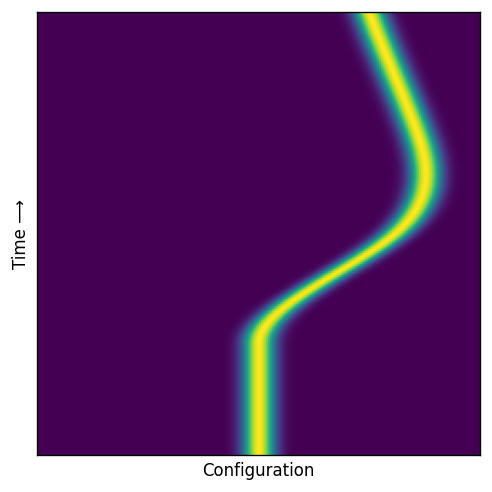

In [5]:
fig, ax = plt.subplots(dpi=120)
ts = np.linspace(0, 1, 200)  # (T,)
xs = np.linspace(-1, 1, 200)  # (X,)
ts, xs = np.meshgrid(ts, xs, indexing='ij')  # (T, X)
im = plot_probability_density(fp, ts, xs, plt.gca(), normalize=False)
# plt.tight_layout()
plt.show()

## Plot conditional vector field of right trajectory

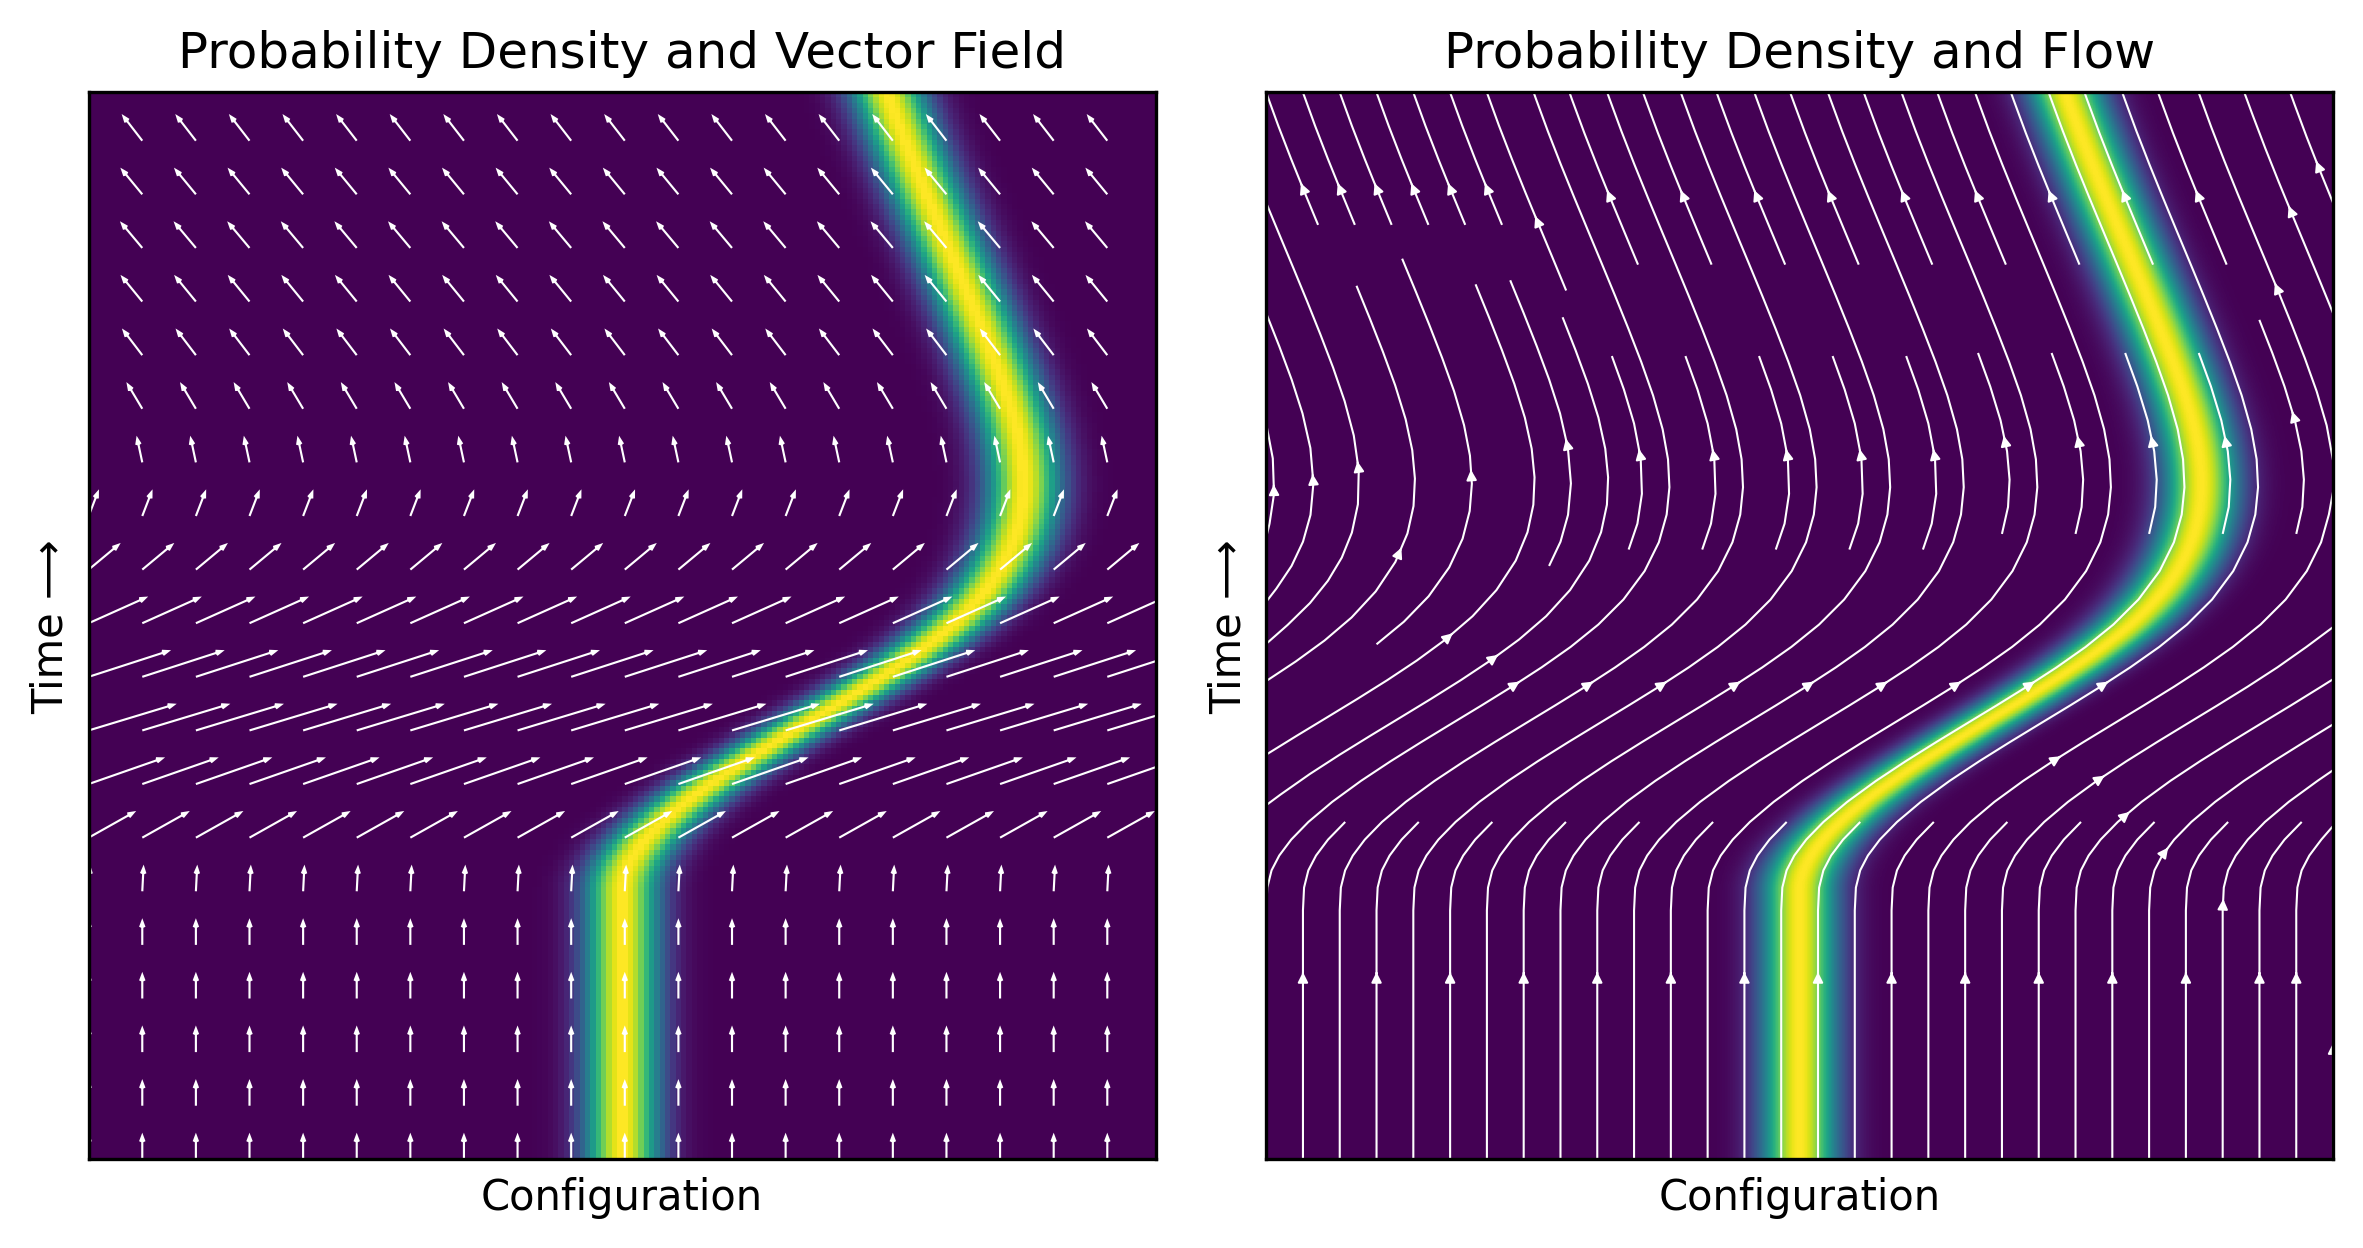

In [6]:
fig = plt.figure(figsize=(8, 4), dpi=300)
gs = fig.add_gridspec(1, 2, width_ratios=[1, 1])
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
im1 = plot_probability_density_and_vector_field(fp, ax1)
im2 = plot_probability_density_and_streamlines(fp, ax2)
plt.tight_layout()  # Uncommented to adjust spacing
plt.show()

## Plot trajectories under conditional flow of right trajectory

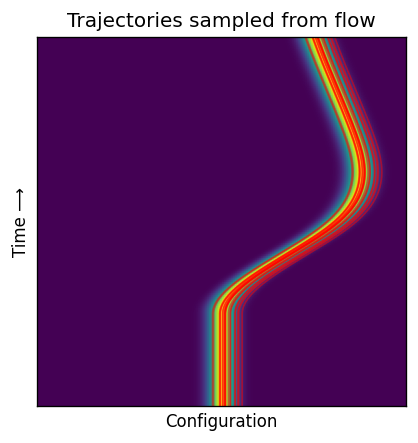

In [7]:
fig, ax = plt.subplots(figsize=(5, 4), dpi=120)
im = plot_probability_density_with_trajectories(fp, ax, [None] * 20)
plt.show()


# Marginal flow

In [8]:
fp = FlowPolicy(trajectories=[traj_right, traj_left], prior=[0.5, 0.5], sigma=0.05)

## Training

Flow matching loss:
$$\mathcal{L}_\mathrm{FM}(\theta, \mathcal{D}) = \mathbb{E}_{\xi \sim \mathcal{D},\ t,\ q \sim \mathcal{N}\left(\xi(t), \sigma^2\right)} \big\| v_\theta(q, t \mid o) - v(q, t \mid \xi) \big\|_2^2$$

1. Sample trajectory from dataset $\xi \sim \mathcal{D}$.
2. Define conditional flow $v(q, t \mid \xi) = \dot{\xi}(t)$.
3. Sample $t \sim \text{Uniform}([0, 1])$.
4. Sample $q \sim \mathcal{N}(\xi(t), \sigma^2)$.
5. Compute L2 loss: $\| v_\theta(q, t \mid o) - v(q, t \mid \xi) \|_2^2$.


### Flow matching theorem

If $v^*(q, t \mid o)$ is the optimal velocity field that minimizes the flow matching loss, then the marginal distributions $p^*(q \mid t, o)$ induced by $v^*$ at *every* time $t$ is the "average" of the conditional flow distributions $p(q \mid t, \xi)$ averaged over the training distribution.

$$p^*(q \mid t, o) = \mathbb{E}_{\xi} \left[ p(q \mid t, \xi) \right], \ \forall q \in \mathbb{C}, \forall t \in [0, 1]$$

## Plot marginal probability path

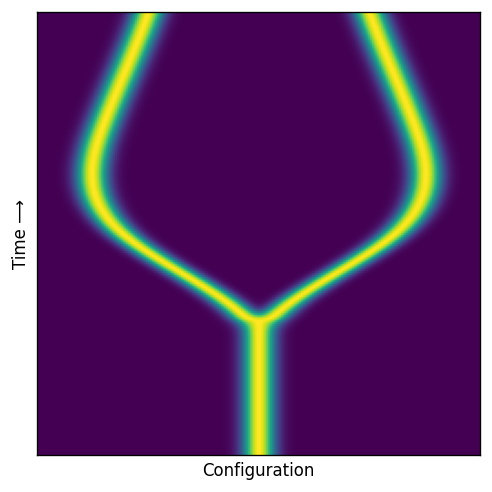

In [9]:
fig, ax = plt.subplots(dpi=120)
ts = np.linspace(0, 1, 200)  # (T,)
xs = np.linspace(-1, 1, 200)  # (X,)
ts, xs = np.meshgrid(ts, xs, indexing='ij')  # (T, X)
im = plot_probability_density(fp, ts, xs, plt.gca(), normalize=True)
# plt.tight_layout()
plt.show()


## Plot marginal vector field

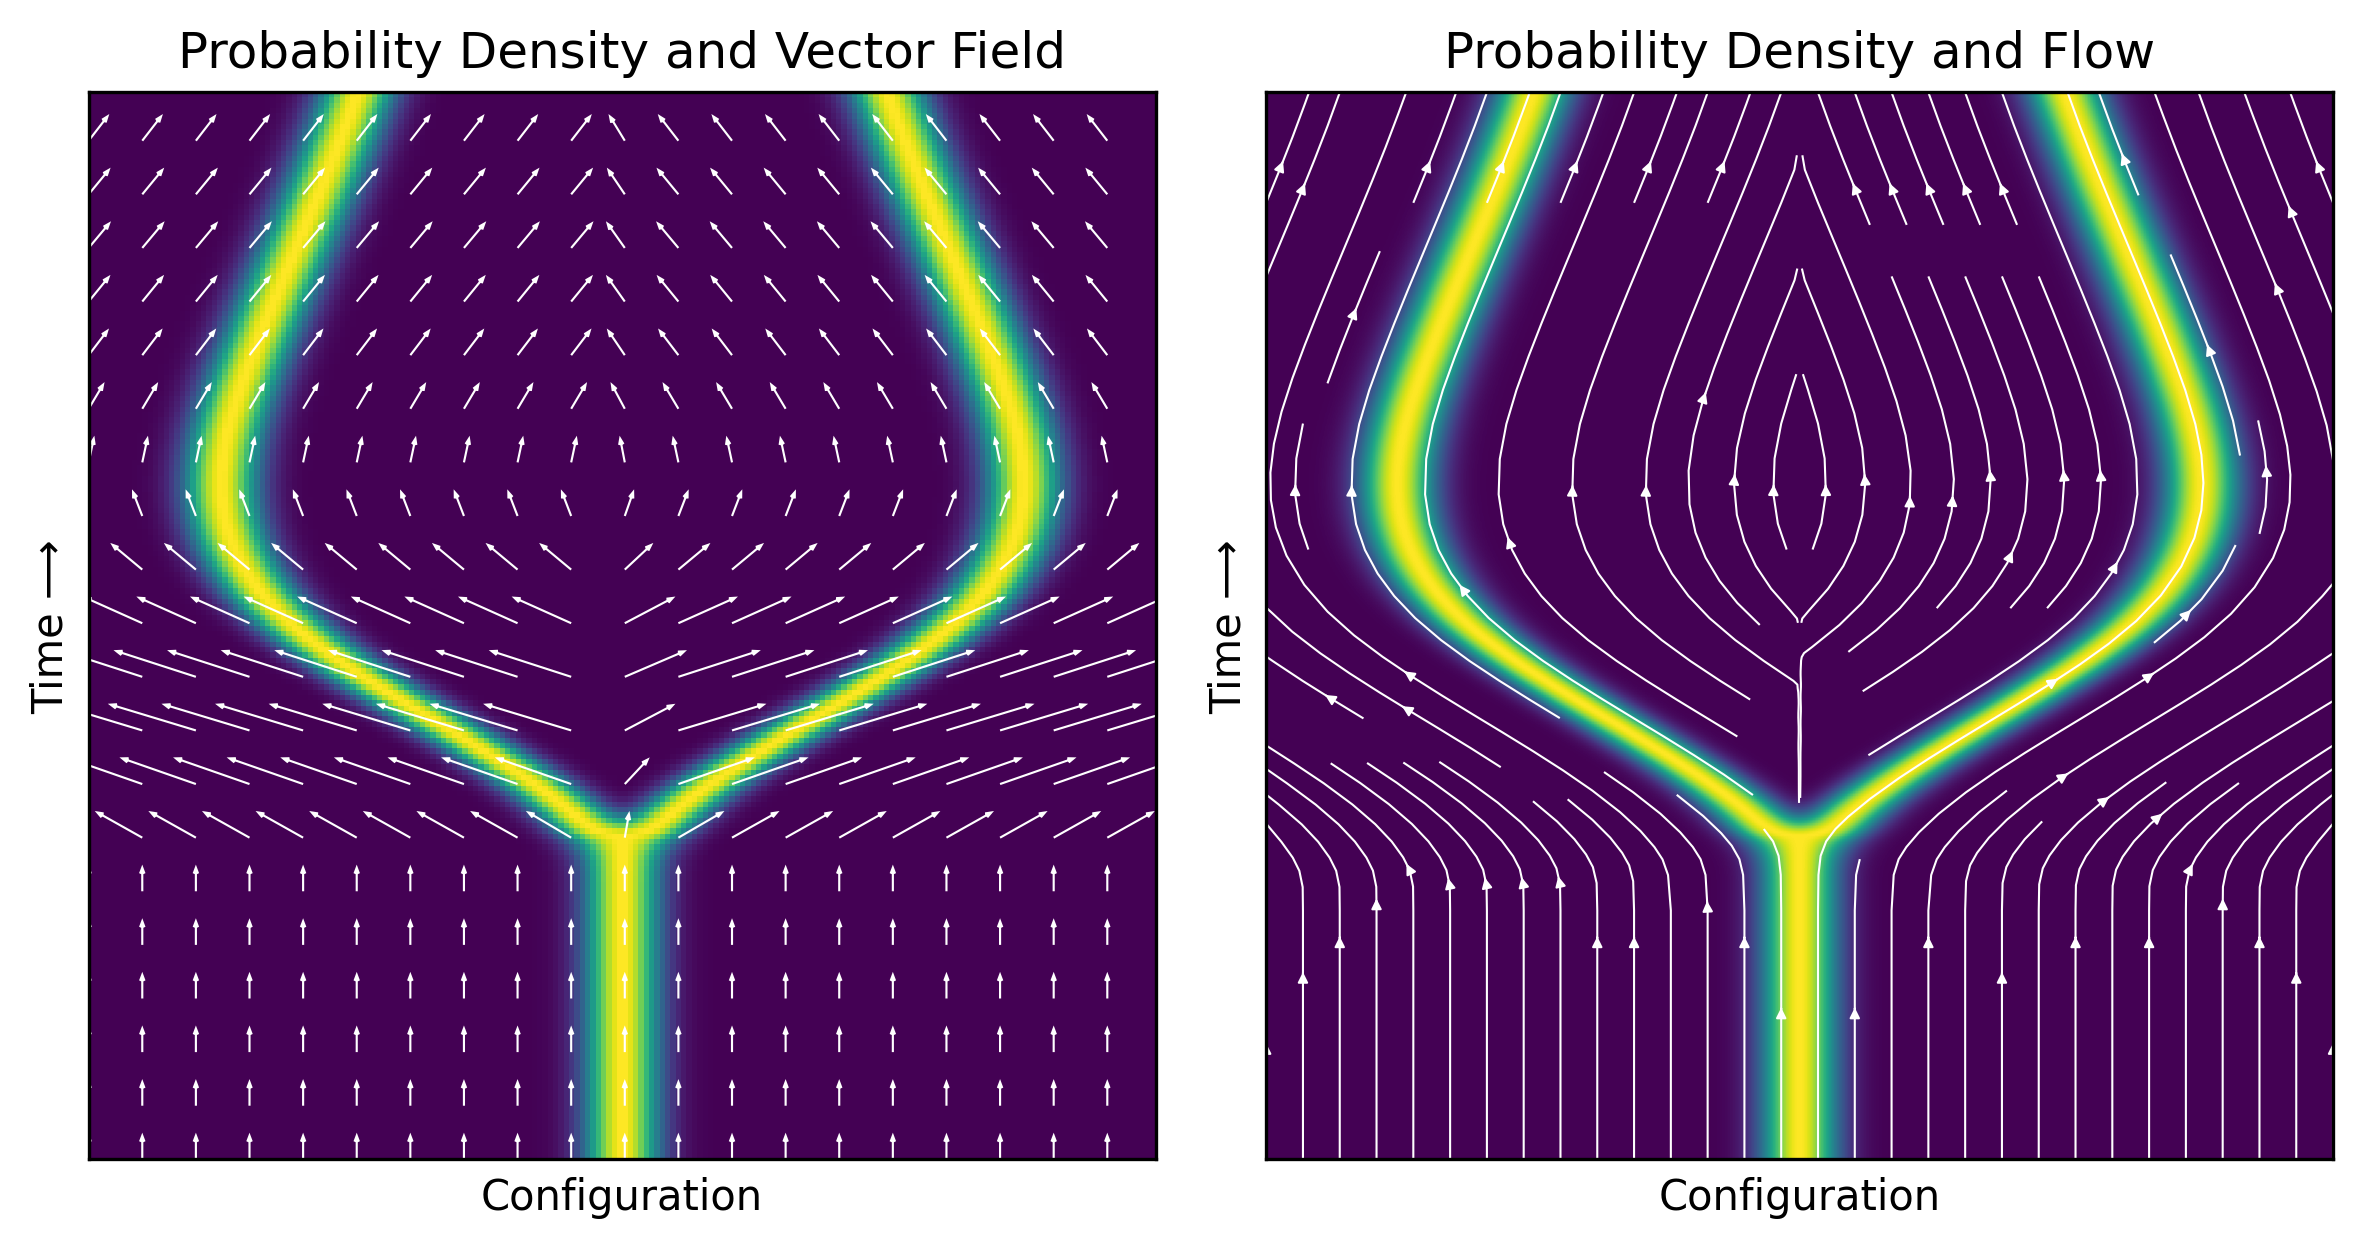

In [10]:
fig = plt.figure(figsize=(8, 4), dpi=300)
gs = fig.add_gridspec(1, 2, width_ratios=[1, 1])
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
im1 = plot_probability_density_and_vector_field(fp, ax1)
im2 = plot_probability_density_and_streamlines(fp, ax2)
plt.tight_layout()  # Uncommented to adjust spacing
plt.show()

## Plot trajectories under marginal flow

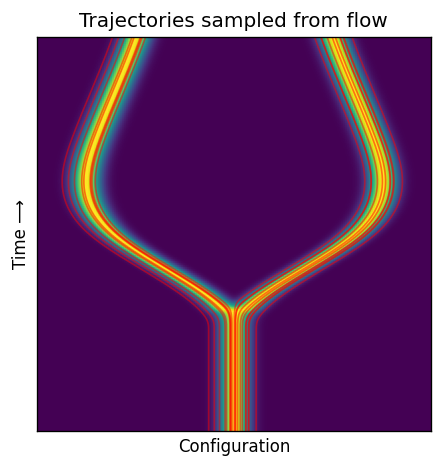

In [11]:
fig, ax = plt.subplots(figsize=(5, 4), dpi=120)
im = plot_probability_density_with_trajectories(fp, ax, [None] * 20)
plt.tight_layout()
plt.show()

# Pathology when starting from $q=0$

Let us compute the trajectory from the current configuration $q=0$.

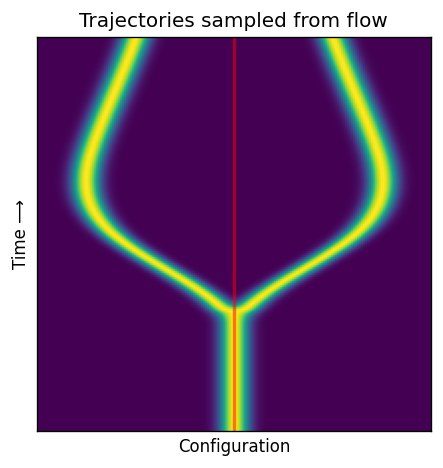

In [12]:
fig, ax = plt.subplots(figsize=(5, 4), dpi=120)
im = plot_probability_density_with_trajectories(fp, ax, [0], linewidth=2)
plt.tight_layout()
plt.show()

### Explanation

This is due to:
1. The flow being a deterministic. Which means that for a fixed starting point (i.e. initial configuration), the trajectory is fixed.
2. In this particular example, the demonstration trajectories are symmetric. This causes the learned velocity field to be zero at $q=0$ for all $t \in [0, 1]$. Therefor, the sampled trajectory is pathological.

The sampled trajectory is not near the demonstration trajectories. Flow matching only guarantees that the marginal distribution of configurations is matched at each timestep. Note that the probability of exactly sampling the pathological trajectory is zero, so the flow matching guarantees are satisfied.